In [1]:
import json
import random
import warnings
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adagrad
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import class_weight
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

Using TensorFlow backend.
/home/akoksal/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/akoksal/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/akoksal/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/akoksal/.local/lib/python3.6/site-packages/tensorflow/py

In [2]:
train_path = 'Boun Twitter Data/train.json'
val_path = 'Boun Twitter Data/validation.json'
test_path = 'Boun Twitter Data/test.json'
cappy_path = 'Other Data/cappy.json'
bege_path = 'Other Data/berkcan.json'
netflix_path = 'Other Data/netflix.json'
device = 'cuda'

In [3]:
def filter(text):
    final_text = ''
    for word in text.split():
        if word.startswith('@'):
            continue
        elif word[-3:] in ['com', 'org']:
            continue
        elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
            continue
        else:
            final_text += word+' '
    return final_text

In [4]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")
bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-128k-uncased").to(device)

def feature_extraction(text):
    x = tokenizer.encode(filter(text))
    with torch.no_grad():
        x, _ = bert(torch.stack([torch.tensor(x)]).to(device))
        return list(x[0][0].cpu().numpy())

In [5]:
with open(train_path, 'r') as f:
    train = json.load(f)
with open(val_path, 'r') as f:
    val = json.load(f)
with open(test_path, 'r') as f:
    test = json.load(f)


In [6]:
mapping = {'negative':0, 'neutral':1, 'positive':2}
def data_prep(dataset):
    X = []
    y = []
    for element in tqdm(dataset):
        X.append(feature_extraction(element['sentence']))
        y_val = np.zeros(3)
        y_val[mapping[element['value']]] = 1
        y.append(y_val)
    return np.array(X), np.array(y)

X_train, y_train = data_prep(train)
X_val, y_val = data_prep(val)
X_test, y_test = data_prep(test)

100%|██████████| 1592/1592 [00:11<00:00, 144.64it/s]


## Training a Model with Keras

In [7]:
class_counts = [0, 0, 0]
for el in y_train:
    class_counts[np.argmax(el)]+=1
class_weights = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

model = Sequential()
model.add(Dense(512, activation='tanh', input_shape=(768,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               393728    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
________________________________________________

In [8]:
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size=64,
                    epochs=500,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights,
                    callbacks = [es])

Instructions for updating:
Use tf.cast instead.
Train on 5733 samples, validate on 639 samples
Epoch 1/500
5733/5733 [==============================] - 0s 73us/step - loss: 4.1559 - accuracy: 0.3373 - val_loss: 1.0409 - val_accuracy: 0.5290
Epoch 2/500
5733/5733 [==============================] - 0s 41us/step - loss: 3.6342 - accuracy: 0.3937 - val_loss: 0.9153 - val_accuracy: 0.5540
Epoch 3/500
5733/5733 [==============================] - 0s 58us/step - loss: 3.3256 - accuracy: 0.4629 - val_loss: 0.9112 - val_accuracy: 0.6166
Epoch 4/500
5733/5733 [==============================] - 0s 86us/step - loss: 3.1395 - accuracy: 0.5022 - val_loss: 0.9958 - val_accuracy: 0.5008
Epoch 5/500
5733/5733 [==============================] - 1s 121us/step - loss: 3.0775 - accuracy: 0.5245 - val_loss: 1.0622 - val_accuracy: 0.5696
Epoch 6/500
5733/5733 [==============================] - 1s 121us/step - loss: 2.9340 - accuracy: 0.5538 - val_loss: 0.9417 - val_accuracy: 0.6056
Epoch 7/500
5733/5733 [====

5733/5733 [==============================] - 1s 113us/step - loss: 2.0729 - accuracy: 0.7268 - val_loss: 0.9299 - val_accuracy: 0.6322
Epoch 55/500
5733/5733 [==============================] - 1s 121us/step - loss: 2.0570 - accuracy: 0.7316 - val_loss: 0.8855 - val_accuracy: 0.6651
Epoch 56/500
5733/5733 [==============================] - 0s 58us/step - loss: 2.0233 - accuracy: 0.7328 - val_loss: 0.8755 - val_accuracy: 0.6588
Epoch 57/500
5733/5733 [==============================] - 0s 61us/step - loss: 2.0803 - accuracy: 0.7228 - val_loss: 0.8805 - val_accuracy: 0.6651
Epoch 58/500
5733/5733 [==============================] - 1s 121us/step - loss: 2.0341 - accuracy: 0.7319 - val_loss: 0.9308 - val_accuracy: 0.6369
Epoch 59/500
5733/5733 [==============================] - 1s 121us/step - loss: 2.0171 - accuracy: 0.7323 - val_loss: 0.8759 - val_accuracy: 0.6667
Epoch 60/500
5733/5733 [==============================] - 0s 56us/step - loss: 2.0372 - accuracy: 0.7324 - val_loss: 0.8936 - v

In [9]:
y_true, y_pred = np.argmax(y_test, 1), np.argmax(model.predict(X_test), 1)
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.507     0.668     0.576       280
           1      0.839     0.667     0.743       843
           2      0.566     0.667     0.613       469

    accuracy                          0.667      1592
   macro avg      0.637     0.667     0.644      1592
weighted avg      0.700     0.667     0.675      1592



# Analysis

## Cappy Analysis

In [13]:
cappy_df = pd.read_json(cappy_path).query('is_retweet==False').drop_duplicates(['text'])[['text', 'datetime']]
cappy_df['value'] = 0
#-1 negative 0 neutral 1 positive
for idx, row in tqdm(cappy_df.iterrows()):
    X = feature_extraction(row['text'])
    cappy_df.at[idx, 'value'] = np.argmax(model.predict(np.array(X).reshape(1, -1)))-1

13717it [02:09, 105.96it/s]


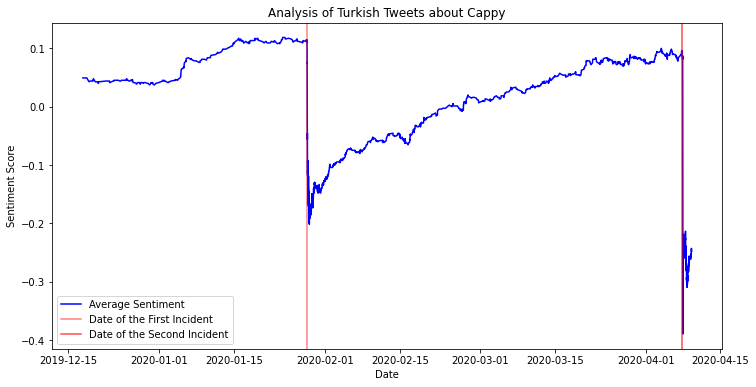

In [14]:
incident1 = datetime.strptime('2020-01-28 15:20:00', '%Y-%m-%d %H:%M:%S')
incident2 = datetime.strptime('2020-04-07 19:34:00', '%Y-%m-%d %H:%M:%S')
dates = np.array(cappy_df['datetime'])
indices = np.argsort(dates)[5300:]
window = 750

dates = dates[indices][window:]
values = np.array(cappy_df['value'])[indices]
windows = pd.Series(values).rolling(window)
moving_averages = windows.mean()[window:]


plt.figure(figsize=(12,6))
plt.plot(dates, moving_averages, color='blue', label='Average Sentiment')

plt.axvline(incident1, 0, 1, label='Date of the First Incident', color='red', alpha=0.5)
plt.axvline(incident2, 0, 1, label='Date of the Second Incident', color='red', alpha=0.7)
plt.title('Analysis of Turkish Tweets about Cappy')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend();

## Netflix Analysis

In [15]:
netflix_df = pd.read_json(netflix_path).query('is_retweet==False').drop_duplicates(['text'])[['text', 'datetime']]
netflix_df['value'] = 0
#-1 negative 0 neutral 1 positive
for idx, row in tqdm(netflix_df.iterrows()):
    X = feature_extraction(row['text'])
    netflix_df.at[idx, 'value'] = np.argmax(model.predict(np.array(X).reshape(1, -1)))-1

13948it [02:12, 105.28it/s]


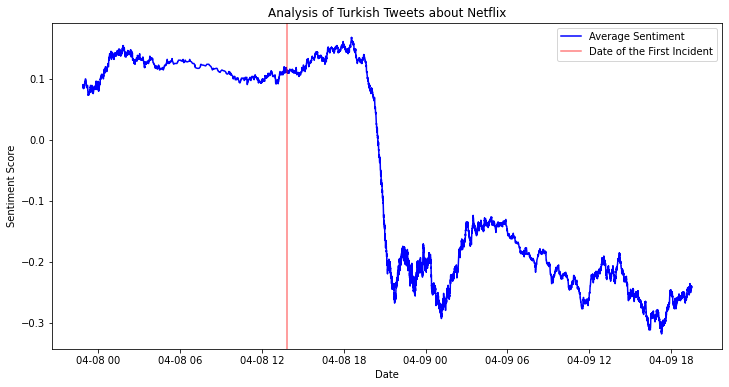

In [16]:
incident1 = datetime.strptime('2020-04-08 13:48:00', '%Y-%m-%d %H:%M:%S')
dates = np.array(netflix_df['datetime'])
indices = np.argsort(dates)
window = 750

dates = dates[indices][window:]
values = np.array(netflix_df['value'])[indices]
windows = pd.Series(values).rolling(window)
moving_averages = windows.mean()[window:]


plt.figure(figsize=(12,6))
plt.plot(dates, moving_averages, color='blue', label='Average Sentiment')

plt.axvline(incident1, 0, 1, label='Date of the First Incident', color='red', alpha=0.5)
plt.title('Analysis of Turkish Tweets about Netflix')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend();

## Berkcan Guven Analysis

In [17]:
bege_df = pd.read_json(bege_path).query('is_retweet==False').drop_duplicates(['text'])[['text', 'datetime']]
bege_df['value'] = 0
#-1 negative 0 neutral 1 positive
for idx, row in tqdm(bege_df.iterrows()):
    X = feature_extraction(row['text'])
    bege_df.at[idx, 'value'] = np.argmax(model.predict(np.array(X).reshape(1, -1)))-1

14274it [02:12, 107.38it/s]


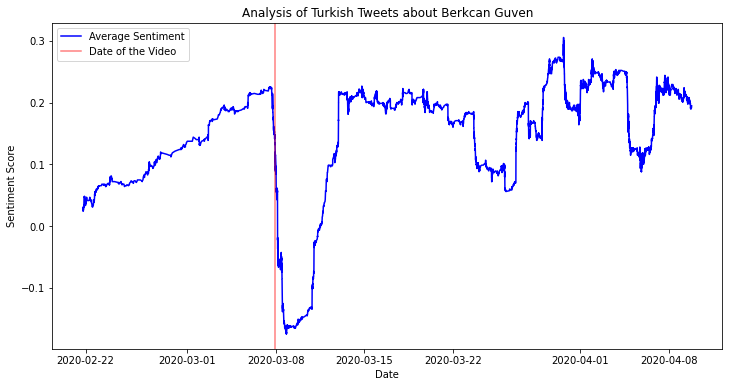

In [18]:
incident1 = datetime.strptime('2020-03-07 23:11:00', '%Y-%m-%d %H:%M:%S')
dates = np.array(bege_df['datetime'])
indices = np.argsort(dates)
window = 750

dates = dates[indices][window:]
values = np.array(bege_df['value'])[indices]
windows = pd.Series(values).rolling(window)
moving_averages = windows.mean()[window:]


plt.figure(figsize=(12,6))
plt.plot(dates, moving_averages, color='blue', label='Average Sentiment')

plt.axvline(incident1, 0, 1, label='Date of the Video', color='red', alpha=0.5)
plt.title('Analysis of Turkish Tweets about Berkcan Guven')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend();